# Exploratory Data Analysis — AQI Predictor
**Location:** Hyderabad, Sindh, Pakistan  
**Data Source:** Open-Meteo Air Quality + Weather APIs  
**Target:** US AQI (US EPA Scale, 0–500)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
import sys, os

sys.path.append(os.path.abspath('..'))
from src.database import get_db_client
import src.config as config

sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

## 1. Load Data from MongoDB

In [2]:
db = get_db_client()
data = list(db[config.FEATURE_COLLECTION].find({}, {'_id': 0}).sort('time', 1))
df = pd.DataFrame(data)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

print(f'Records: {len(df)}')
print(f'Date range: {df.index.min()} to {df.index.max()}')
print(f'Duration: {(df.index.max() - df.index.min()).days} days')
print(f'Columns: {list(df.columns)}')
df.head()

[SUCCESS] Connected to MongoDB!
Records: 4584
Date range: 2025-08-11 00:00:00 to 2026-02-17 23:00:00
Duration: 190 days
Columns: ['temp', 'humidity', 'rain', 'wind_speed', 'weather_code', 'pm2_5', 'pm10', 'no2', 'ozone', 'us_aqi', 'city']


,temp,humidity,rain,wind_speed,weather_code,pm2_5,pm10,no2,ozone,us_aqi,city
time,,,,,,,,,,,
2025-08-11 00:00:00,27.2,80,0.0,17.7,0,17.4,36.8,6.8,41.0,66.0,Hyderabad
2025-08-11 01:00:00,27.0,81,0.0,17.1,1,16.9,36.2,6.8,41.0,66.0,Hyderabad
2025-08-11 02:00:00,26.8,82,0.0,17.2,0,16.7,35.4,6.7,42.0,66.0,Hyderabad
2025-08-11 03:00:00,26.5,83,0.0,16.6,0,16.4,34.6,6.5,42.0,66.0,Hyderabad
2025-08-11 04:00:00,26.3,84,0.0,16.7,0,15.8,33.2,6.2,42.0,67.0,Hyderabad


## 2. Data Overview & Missing Values

In [3]:
print('=== Column Statistics ===')
for col in df.select_dtypes(include=[np.number]).columns:
    nulls = df[col].isnull().sum()
    print(f'  {col:20s} | nulls={nulls:4d} | range=[{df[col].min():.1f}, {df[col].max():.1f}] | mean={df[col].mean():.1f}')

# Check for time gaps
time_diffs = df.index.to_series().diff().dropna()
gaps = time_diffs[time_diffs > pd.Timedelta(hours=1)]
print(f'\nTime gaps > 1 hour: {len(gaps)}')
if len(gaps) > 0:
    for t, gap in gaps.items():
        print(f'  {t}: {gap}')

=== Column Statistics ===
  temp                 | nulls=   0 | range=[7.3, 39.3] | mean=24.1
  humidity             | nulls=   0 | range=[9.0, 99.0] | mean=55.6
  rain                 | nulls=   0 | range=[0.0, 12.5] | mean=0.0
  wind_speed           | nulls=   0 | range=[0.0, 25.9] | mean=9.4
  weather_code         | nulls=   0 | range=[0.0, 65.0] | mean=2.1
  pm2_5                | nulls= 207 | range=[5.9, 105.5] | mean=32.9
  pm10                 | nulls=   0 | range=[6.0, 172.3] | mean=45.8
  no2                  | nulls=   0 | range=[0.7, 57.6] | mean=11.5
  ozone                | nulls=   0 | range=[14.0, 172.0] | mean=77.5
  us_aqi               | nulls=  24 | range=[34.0, 163.0] | mean=95.1

Time gaps > 1 hour: 0


## 3. Target Variable (US AQI) Distribution

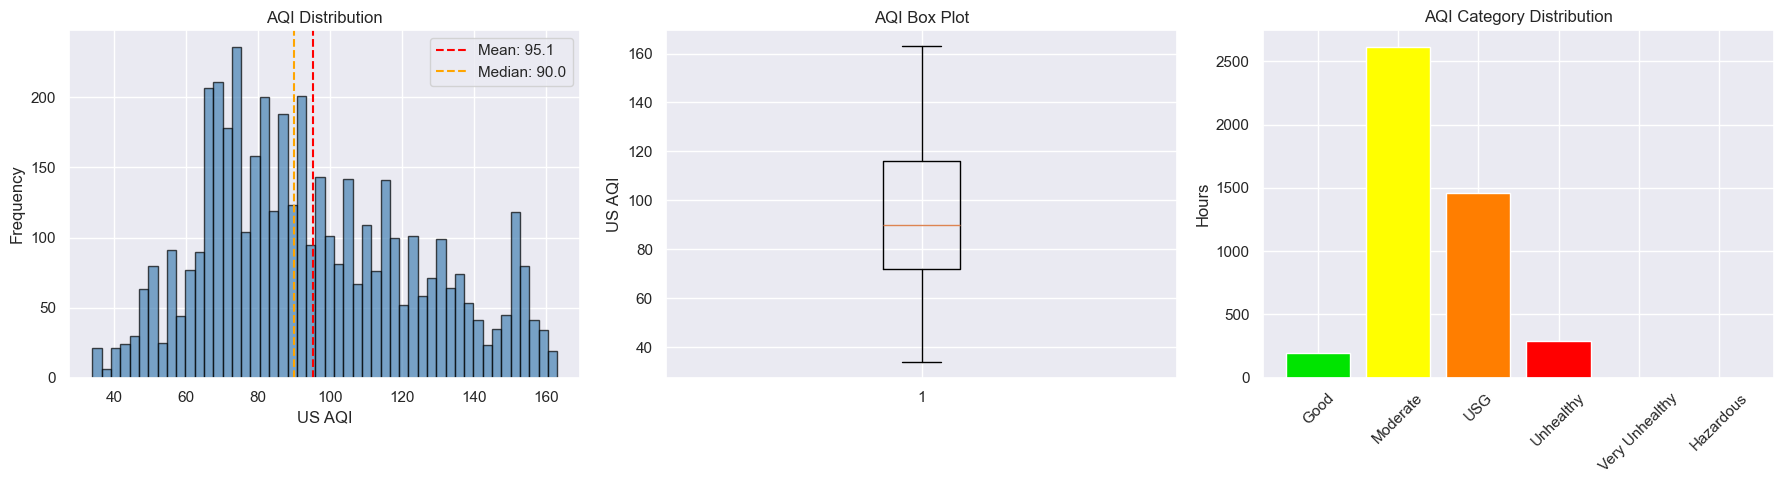


AQI Category Breakdown:
  Good                :   192 (4.2%)
  Moderate            :  2615 (57.0%)
  USG                 :  1461 (31.9%)
  Unhealthy           :   292 (6.4%)
  Very Unhealthy      :     0 (0.0%)
  Hazardous           :     0 (0.0%)


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['us_aqi'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['us_aqi'].mean(), color='red', linestyle='--', label=f'Mean: {df["us_aqi"].mean():.1f}')
axes[0].axvline(df['us_aqi'].median(), color='orange', linestyle='--', label=f'Median: {df["us_aqi"].median():.1f}')
axes[0].set_xlabel('US AQI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('AQI Distribution')
axes[0].legend()

# Box plot
axes[1].boxplot(df['us_aqi'].dropna(), vert=True)
axes[1].set_ylabel('US AQI')
axes[1].set_title('AQI Box Plot')

# AQI categories
cats = pd.cut(df['us_aqi'], bins=[0, 50, 100, 150, 200, 300, 500],
              labels=['Good', 'Moderate', 'USG', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
cat_counts = cats.value_counts().sort_index()
colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']
axes[2].bar(cat_counts.index, cat_counts.values, color=colors[:len(cat_counts)])
axes[2].set_ylabel('Hours')
axes[2].set_title('AQI Category Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print('\nAQI Category Breakdown:')
for cat, count in cat_counts.items():
    print(f'  {cat:20s}: {count:5d} ({count/len(df)*100:.1f}%)')

## 4. Time Series Plot

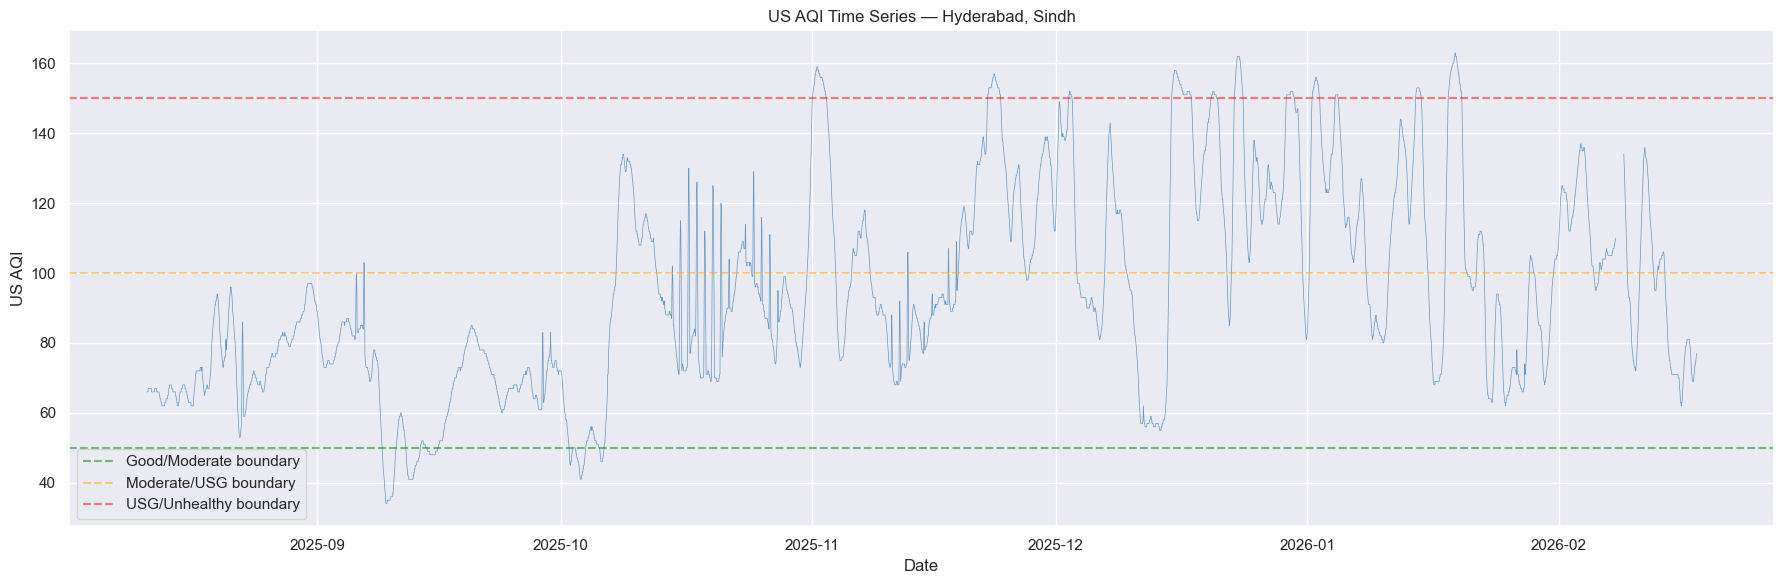

In [5]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df.index, df['us_aqi'], linewidth=0.5, alpha=0.8, color='steelblue')
ax.axhline(50, color='green', linestyle='--', alpha=0.5, label='Good/Moderate boundary')
ax.axhline(100, color='orange', linestyle='--', alpha=0.5, label='Moderate/USG boundary')
ax.axhline(150, color='red', linestyle='--', alpha=0.5, label='USG/Unhealthy boundary')
ax.set_xlabel('Date')
ax.set_ylabel('US AQI')
ax.set_title('US AQI Time Series — Hyderabad, Sindh')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Hourly and Day-of-Week Patterns

Peak AQI hour: 19:00 (AQI=97.8)
Lowest AQI hour: 13:00 (AQI=94.4)
Variation: 3.4 AQI

Weekday avg: 94.8
Weekend avg: 96.0


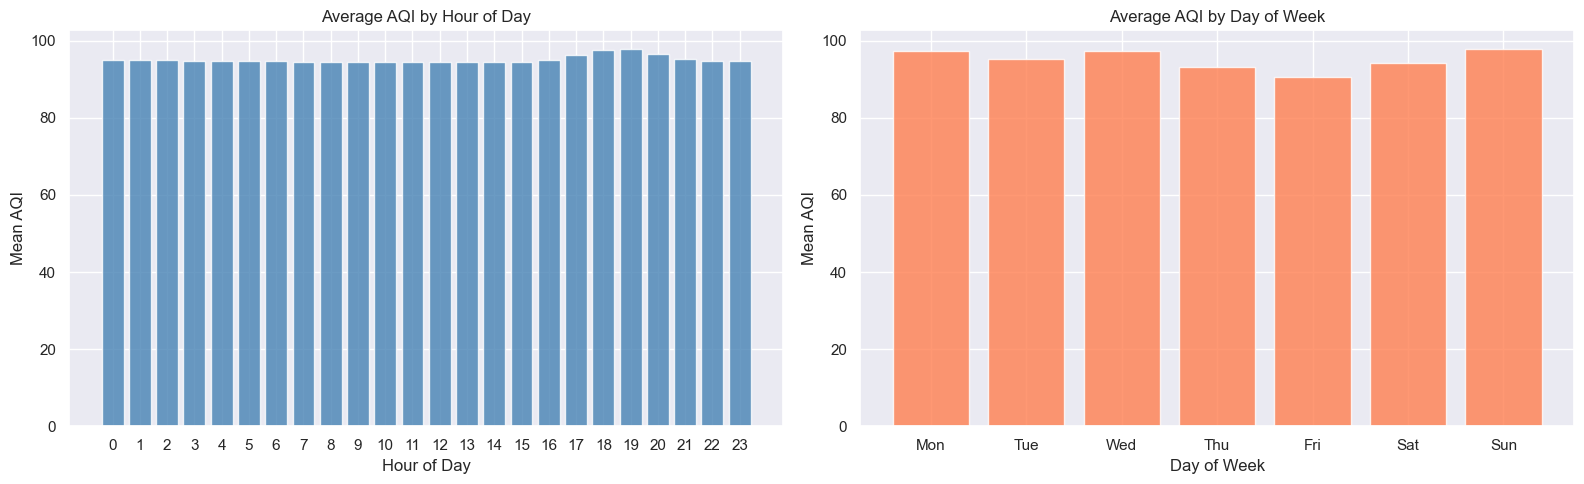

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Hourly pattern
hourly = df.groupby(df.index.hour)['us_aqi'].mean()
axes[0].bar(hourly.index, hourly.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Mean AQI')
axes[0].set_title('Average AQI by Hour of Day')
axes[0].set_xticks(range(0, 24))

peak_h = hourly.idxmax()
low_h = hourly.idxmin()
print(f'Peak AQI hour: {peak_h}:00 (AQI={hourly[peak_h]:.1f})')
print(f'Lowest AQI hour: {low_h}:00 (AQI={hourly[low_h]:.1f})')
print(f'Variation: {hourly.max() - hourly.min():.1f} AQI')

# Day of week pattern
dow = df.groupby(df.index.dayofweek)['us_aqi'].mean()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(dow_names, dow.values, color='coral', alpha=0.8)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Mean AQI')
axes[1].set_title('Average AQI by Day of Week')

print(f'\nWeekday avg: {dow[:5].mean():.1f}')
print(f'Weekend avg: {dow[5:].mean():.1f}')

plt.tight_layout()
plt.show()

## 6. Autocorrelation Analysis
How well does past AQI predict future AQI?

  Lag   1h: r = 0.997
  Lag   3h: r = 0.981
  Lag   6h: r = 0.953
  Lag  12h: r = 0.886
  Lag  24h: r = 0.739
  Lag  48h: r = 0.549
  Lag  72h: r = 0.453


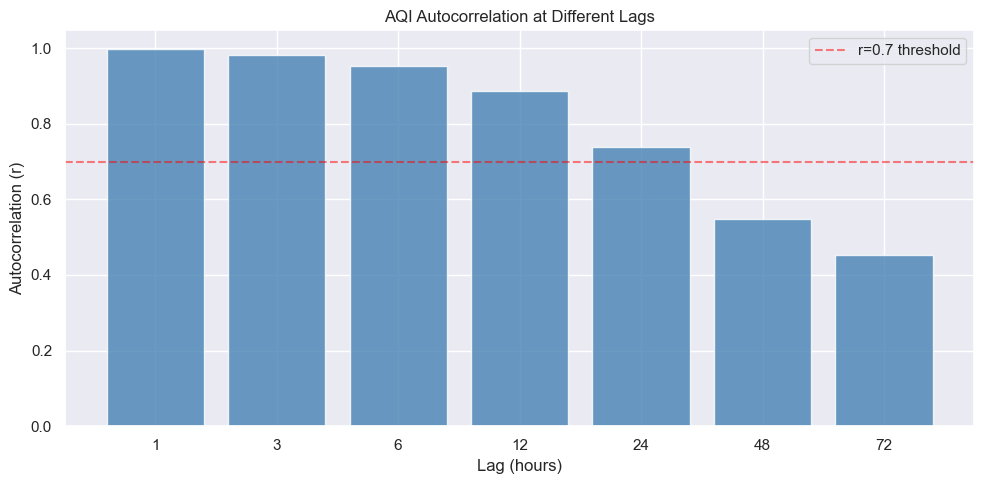


Key finding: AQI is highly persistent (r=0.74 at 24h lag).
This means lag features will be our strongest predictors.


In [7]:
lags = [1, 3, 6, 12, 24, 48, 72]
autocorrs = []

aqi = df['us_aqi'].dropna()
for lag in lags:
    corr = aqi.corr(aqi.shift(lag))
    autocorrs.append(corr)
    print(f'  Lag {lag:3d}h: r = {corr:.3f}')

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([str(l) for l in lags], autocorrs, color='steelblue', alpha=0.8)
ax.set_xlabel('Lag (hours)')
ax.set_ylabel('Autocorrelation (r)')
ax.set_title('AQI Autocorrelation at Different Lags')
ax.axhline(0.7, color='red', linestyle='--', alpha=0.5, label='r=0.7 threshold')
ax.legend()
plt.tight_layout()
plt.show()

print('\nKey finding: AQI is highly persistent (r=0.74 at 24h lag).')
print('This means lag features will be our strongest predictors.')

## 7. Weather vs AQI Correlations

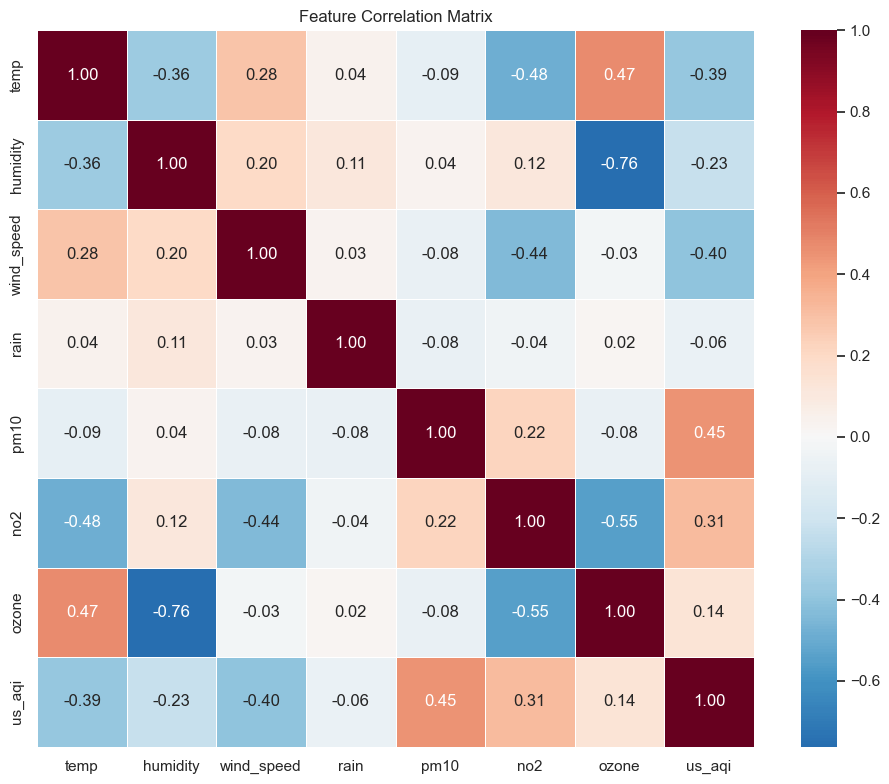


Correlations with US AQI:
  pm10           : r = +0.446  (Higher value → HIGHER AQI)
  wind_speed     : r = -0.400  (Higher value → LOWER AQI)
  temp           : r = -0.387  (Higher value → LOWER AQI)
  no2            : r = +0.314  (Higher value → HIGHER AQI)
  humidity       : r = -0.229  (Higher value → LOWER AQI)
  ozone          : r = +0.136  (Higher value → HIGHER AQI)
  rain           : r = -0.064  (Higher value → LOWER AQI)


In [8]:
weather_cols = ['temp', 'humidity', 'wind_speed', 'rain']
pollutant_cols = ['pm10', 'no2', 'ozone']
all_cols = weather_cols + pollutant_cols + ['us_aqi']

corr_matrix = df[all_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax,
            square=True, linewidths=0.5)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print('\nCorrelations with US AQI:')
aqi_corr = corr_matrix['us_aqi'].drop('us_aqi').sort_values(key=abs, ascending=False)
for col, corr in aqi_corr.items():
    direction = 'Higher value → LOWER AQI' if corr < 0 else 'Higher value → HIGHER AQI'
    print(f'  {col:15s}: r = {corr:+.3f}  ({direction})')

## 8. AQI by Temperature and Wind Speed
The two strongest weather predictors from the correlation analysis.

C:\Users\TECHNOSELLERS\AppData\Local\Temp\ipykernel_10756\1273087308.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_aqi = df.groupby('temp_bin')['us_aqi'].mean()
C:\Users\TECHNOSELLERS\AppData\Local\Temp\ipykernel_10756\1273087308.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_aqi = df.groupby('wind_bin')['us_aqi'].mean()


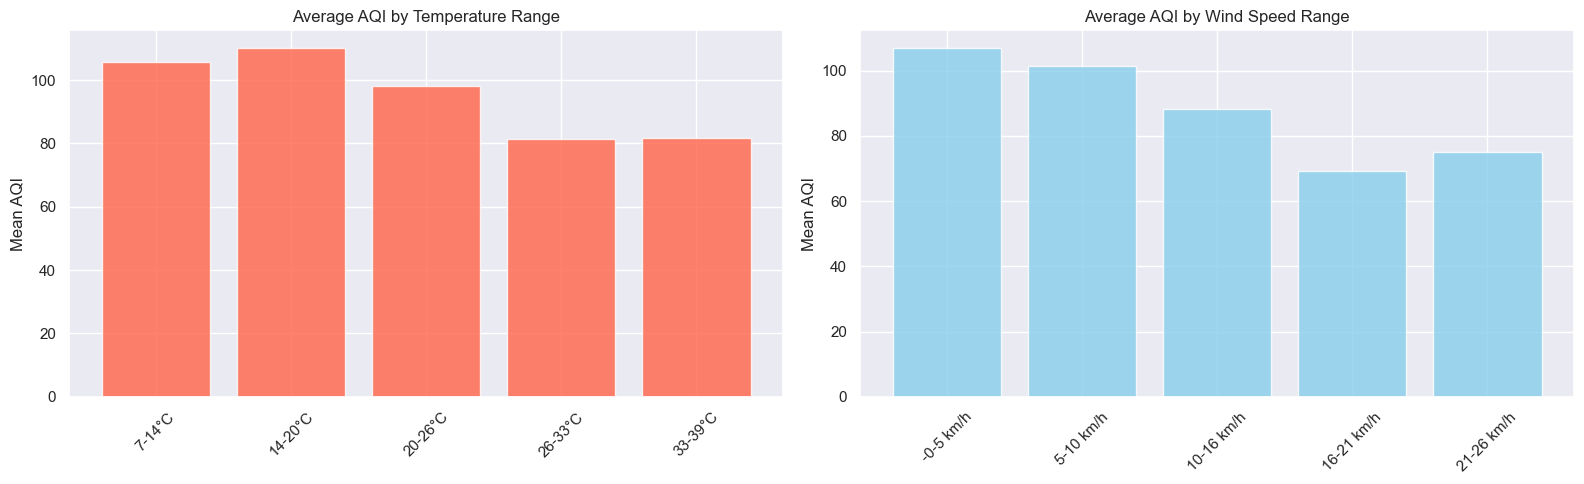


Key finding: Cold + calm = worst AQI (inversions).
Hot + windy = best AQI (mixing and dispersion).


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Temperature bins
df['temp_bin'] = pd.cut(df['temp'], bins=5)
temp_aqi = df.groupby('temp_bin')['us_aqi'].mean()
axes[0].bar(range(len(temp_aqi)), temp_aqi.values, color='tomato', alpha=0.8)
axes[0].set_xticks(range(len(temp_aqi)))
axes[0].set_xticklabels([f'{x.left:.0f}-{x.right:.0f}°C' for x in temp_aqi.index], rotation=45)
axes[0].set_ylabel('Mean AQI')
axes[0].set_title('Average AQI by Temperature Range')

# Wind speed bins
df['wind_bin'] = pd.cut(df['wind_speed'], bins=5)
wind_aqi = df.groupby('wind_bin')['us_aqi'].mean()
axes[1].bar(range(len(wind_aqi)), wind_aqi.values, color='skyblue', alpha=0.8)
axes[1].set_xticks(range(len(wind_aqi)))
axes[1].set_xticklabels([f'{x.left:.0f}-{x.right:.0f} km/h' for x in wind_aqi.index], rotation=45)
axes[1].set_ylabel('Mean AQI')
axes[1].set_title('Average AQI by Wind Speed Range')

plt.tight_layout()
plt.show()

print('\nKey finding: Cold + calm = worst AQI (inversions).')
print('Hot + windy = best AQI (mixing and dispersion).')

## 9. PM2.5 vs AQI Relationship
US AQI in Hyderabad is driven almost entirely by PM2.5.

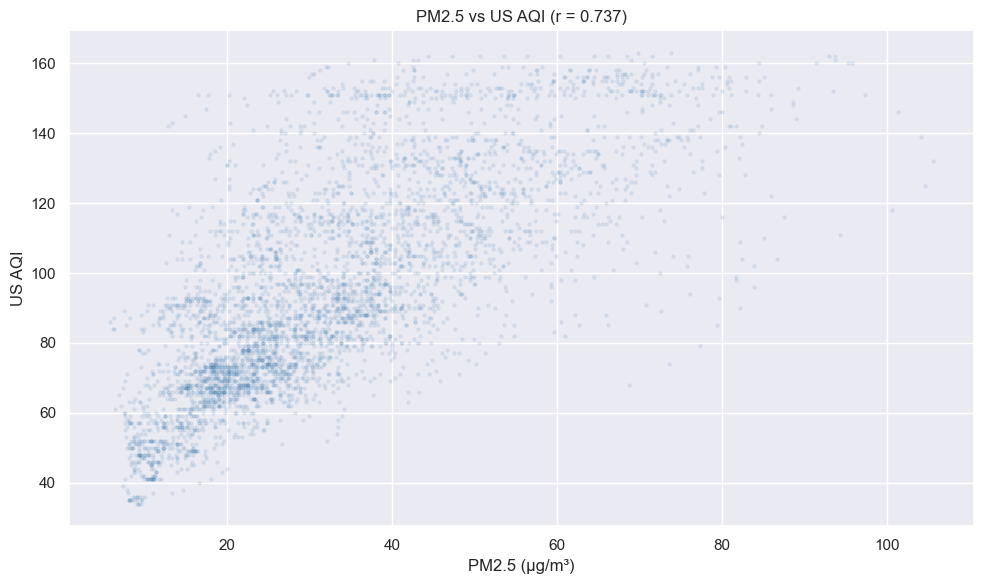

PM2.5 is the dominant pollutant driving AQI in Hyderabad.
This is why we EXCLUDE pm2_5 from model features — it would be data leakage.


In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
valid = df[['pm2_5', 'us_aqi']].dropna()
ax.scatter(valid['pm2_5'], valid['us_aqi'], alpha=0.1, s=5, color='steelblue')
ax.set_xlabel('PM2.5 (µg/m³)')
ax.set_ylabel('US AQI')
ax.set_title(f'PM2.5 vs US AQI (r = {valid["pm2_5"].corr(valid["us_aqi"]):.3f})')
plt.tight_layout()
plt.show()

print('PM2.5 is the dominant pollutant driving AQI in Hyderabad.')
print('This is why we EXCLUDE pm2_5 from model features — it would be data leakage.')

## 10. Feature Design Rationale

Based on the EDA findings, we designed **28 features** in 5 groups:

| Group | Features | Rationale |
|-------|----------|-----------|
| **Weather** | temp, humidity, wind_speed, rain, weather_code | wind (r=-0.40), temp (r=-0.39) are strong predictors |
| **Pollutants** | pm10, no2, ozone | pm10 (r=+0.45) strongest; available from forecast |
| **Cyclical Time** | hour_sin/cos, dow_sin/cos, month_sin/cos | Captures diurnal, weekly, seasonal cycles |
| **Explicit Time** | hour, is_night, is_morning_rush, etc. | Binary indicators for high-AQI periods |
| **Lag/Rolling** | us_aqi_lag_24h, rolling_mean_24h, rolling_std_24h | lag_24h has r=0.739 — strongest predictor |
| **Interactions** | wind_x_temp, humidity_x_temp, pm10_x_humidity | Capture non-linear relationships |

### Excluded from features:
- **us_aqi** — this is the target variable
- **pm2_5** — directly derived from us_aqi (data leakage)
- **city** — constant (always Hyderabad)

## 11. Hyperparameter Tuning (RandomizedSearchCV)

We tune all 3 models — **LightGBM**, **XGBoost**, and **RandomForest** — using `RandomizedSearchCV` with **TimeSeriesSplit** cross-validation to respect temporal ordering.

**Why RandomizedSearchCV over GridSearchCV?**
- Full grid search over 3 models with wide param spaces takes 1-2 hours
- Randomized search with 20 iterations per model runs in ~5-10 minutes
- This is critical because the training pipeline runs **daily at 1 AM PKT** via GitHub Actions (30-min timeout)
- Research shows randomized search finds comparable results to grid search in far less time ([Bergstra & Bengio, 2012](https://jmlr.org/papers/v13/bergstra12a.html))

The best parameters found here are **not hardcoded** into the training pipeline. Instead, the pipeline runs its own `RandomizedSearchCV` each day so that params adapt as data distribution shifts over time.

In [11]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# --- Prepare training data (same pipeline as train_forecast_model.py) ---
TARGET_COL = 'us_aqi'

df_tune = df.copy()

# Engineer features (same as training pipeline)
df_tune['hour_sin'] = np.sin(2 * np.pi * df_tune.index.hour / 24)
df_tune['hour_cos'] = np.cos(2 * np.pi * df_tune.index.hour / 24)
df_tune['dow_sin'] = np.sin(2 * np.pi * df_tune.index.dayofweek / 7)
df_tune['dow_cos'] = np.cos(2 * np.pi * df_tune.index.dayofweek / 7)
df_tune['month_sin'] = np.sin(2 * np.pi * df_tune.index.month / 12)
df_tune['month_cos'] = np.cos(2 * np.pi * df_tune.index.month / 12)
df_tune['hour'] = df_tune.index.hour
df_tune['is_night'] = ((df_tune.index.hour >= 20) | (df_tune.index.hour <= 5)).astype(int)
df_tune['is_morning_rush'] = ((df_tune.index.hour >= 6) & (df_tune.index.hour <= 10)).astype(int)
df_tune['is_afternoon'] = ((df_tune.index.hour >= 11) & (df_tune.index.hour <= 17)).astype(int)
df_tune['is_evening_rush'] = ((df_tune.index.hour >= 17) & (df_tune.index.hour <= 20)).astype(int)
df_tune['is_weekend'] = (df_tune.index.dayofweek >= 5).astype(int)
df_tune[f'{TARGET_COL}_lag_24h'] = df_tune[TARGET_COL].shift(24).bfill().ffill()
df_tune[f'{TARGET_COL}_rolling_mean_24h'] = df_tune[TARGET_COL].rolling(24, min_periods=1).mean().bfill()
df_tune[f'{TARGET_COL}_rolling_std_24h'] = df_tune[TARGET_COL].rolling(24, min_periods=1).std().fillna(0)
df_tune['wind_x_temp'] = df_tune['wind_speed'] * df_tune['temp']
df_tune['humidity_x_temp'] = df_tune['humidity'] * df_tune['temp']
df_tune['wind_x_humidity'] = df_tune['wind_speed'] * df_tune['humidity']
df_tune['pm10_x_humidity'] = df_tune['pm10'] * df_tune['humidity']
df_tune['hour_x_ozone'] = df_tune['hour'] * df_tune['ozone']
df_tune = df_tune.dropna()

FEATURE_COLS = [
    'temp', 'humidity', 'wind_speed', 'rain', 'weather_code',
    'pm10', 'no2', 'ozone',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'hour', 'is_night', 'is_morning_rush', 'is_afternoon', 'is_evening_rush', 'is_weekend',
    f'{TARGET_COL}_lag_24h', f'{TARGET_COL}_rolling_mean_24h', f'{TARGET_COL}_rolling_std_24h',
    'wind_x_temp', 'humidity_x_temp', 'wind_x_humidity', 'pm10_x_humidity', 'hour_x_ozone',
]

X = df_tune[[c for c in FEATURE_COLS if c in df_tune.columns]]
y = df_tune[TARGET_COL]

# Chronological split
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Features: {len(X.columns)}")

# --- Define search spaces ---
tscv = TimeSeriesSplit(n_splits=3)

param_spaces = {
    'LightGBM': {
        'estimator': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
        'params': {
            'n_estimators': [200, 300, 500, 700],
            'max_depth': [5, 8, 12, -1],
            'learning_rate': [0.01, 0.03, 0.05, 0.1],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'min_child_samples': [10, 20, 30, 50],
            'reg_alpha': [0.0, 0.01, 0.1, 1.0],
            'reg_lambda': [0.0, 0.01, 0.1, 1.0],
        }
    },
    'XGBoost': {
        'estimator': xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
        'params': {
            'n_estimators': [200, 300, 500, 700],
            'max_depth': [5, 8, 12, 15],
            'learning_rate': [0.01, 0.03, 0.05, 0.1],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'reg_alpha': [0.0, 0.01, 0.1, 1.0],
            'reg_lambda': [0.0, 0.01, 0.1, 1.0],
        }
    },
    'RandomForest': {
        'estimator': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [3, 5, 10],
            'max_features': ['sqrt', 0.5, 0.8],
        }
    }
}

# --- Run RandomizedSearchCV for each model ---
tuning_results = {}

for name, spec in param_spaces.items():
    print(f"\n{'='*50}")
    print(f"  Tuning {name} (20 iterations, 3-fold TimeSeriesSplit)")
    print(f"{'='*50}")
    
    search = RandomizedSearchCV(
        estimator=spec['estimator'],
        param_distributions=spec['params'],
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    search.fit(X_train, y_train)
    
    # Evaluate on held-out test set
    best_model = search.best_estimator_
    preds = best_model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    tuning_results[name] = {
        'best_params': search.best_params_,
        'cv_mae': -search.best_score_,
        'test_r2': r2,
        'test_mae': mae,
        'test_rmse': rmse,
        'model': best_model
    }
    
    print(f"  Best CV MAE: {-search.best_score_:.2f}")
    print(f"  Test R²:     {r2:.4f}")
    print(f"  Test MAE:    {mae:.2f}")
    print(f"  Test RMSE:   {rmse:.2f}")
    print(f"  Best params: {search.best_params_}")

# --- Summary comparison ---
print(f"\n{'='*60}")
print(f"  TUNING RESULTS SUMMARY")
print(f"{'='*60}")
print(f"  {'Model':<15} {'CV MAE':>8} {'Test R²':>8} {'Test MAE':>8} {'RMSE':>8}")
print(f"  {'-'*55}")

best_name = min(tuning_results, key=lambda k: tuning_results[k]['test_mae'])
for name, r in tuning_results.items():
    star = " ◀ BEST" if name == best_name else ""
    print(f"  {name:<15} {r['cv_mae']:8.2f} {r['test_r2']:8.4f} {r['test_mae']:8.2f} {r['test_rmse']:8.2f}{star}")

print(f"\n  Winner: {best_name} (Test MAE = {tuning_results[best_name]['test_mae']:.2f})")
print(f"\n  Note: The training pipeline runs its own RandomizedSearchCV daily")
print(f"  so parameters adapt as data distribution changes over time.")

Training samples: 3482 | Test samples: 871
Features: 28

  Tuning LightGBM (20 iterations, 3-fold TimeSeriesSplit)
  Best CV MAE: 10.02
  Test R²:     0.8713
  Test MAE:    6.70
  Test RMSE:   9.27
  Best params: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.9}

  Tuning XGBoost (20 iterations, 3-fold TimeSeriesSplit)
  Best CV MAE: 10.14
  Test R²:     0.8724
  Test MAE:    6.54
  Test RMSE:   9.23
  Best params: {'subsample': 0.9, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

  Tuning RandomForest (20 iterations, 3-fold TimeSeriesSplit)
  Best CV MAE: 10.40
  Test R²:     0.8522
  Test MAE:    7.10
  Test RMSE:   9.94
  Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.8, 'max_depth': 15}

  TUNING RESULTS SUMMARY
  Model             CV MAE  T

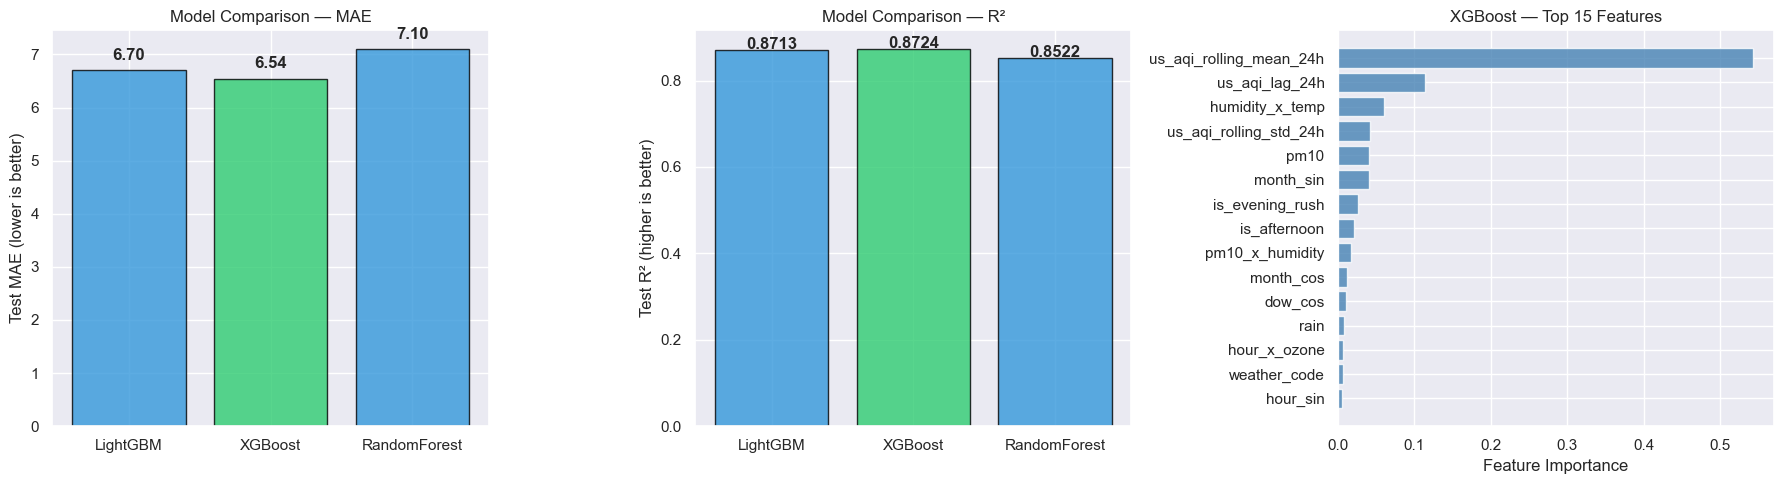


LightGBM best parameters:
  colsample_bytree: 0.9
  learning_rate: 0.05
  max_depth: -1
  min_child_samples: 30
  n_estimators: 500
  reg_alpha: 1.0
  reg_lambda: 1.0
  subsample: 0.7

XGBoost best parameters:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 0.01
  subsample: 0.9

RandomForest best parameters:
  max_depth: 15
  max_features: 0.8
  min_samples_leaf: 5
  min_samples_split: 5
  n_estimators: 200


In [12]:
# --- Visualize tuning results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Model comparison bar chart
models_list = list(tuning_results.keys())
maes = [tuning_results[m]['test_mae'] for m in models_list]
r2s = [tuning_results[m]['test_r2'] for m in models_list]
colors = ['#2ecc71' if m == best_name else '#3498db' for m in models_list]

axes[0].bar(models_list, maes, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Test MAE (lower is better)')
axes[0].set_title('Model Comparison — MAE')
for i, v in enumerate(maes):
    axes[0].text(i, v + 0.2, f'{v:.2f}', ha='center', fontweight='bold')

axes[1].bar(models_list, r2s, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Test R² (higher is better)')
axes[1].set_title('Model Comparison — R²')
for i, v in enumerate(r2s):
    axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Best model's feature importance
best_tuned = tuning_results[best_name]['model']
if hasattr(best_tuned, 'feature_importances_'):
    fi = sorted(zip(X.columns, best_tuned.feature_importances_), key=lambda x: x[1], reverse=True)[:15]
    names, imps = zip(*fi)
    axes[2].barh(range(len(names)), imps, color='steelblue', alpha=0.8)
    axes[2].set_yticks(range(len(names)))
    axes[2].set_yticklabels(names)
    axes[2].invert_yaxis()
    axes[2].set_xlabel('Feature Importance')
    axes[2].set_title(f'{best_name} — Top 15 Features')

plt.tight_layout()
plt.show()

# Print best params for each model
for name, r in tuning_results.items():
    print(f"\n{name} best parameters:")
    for param, value in sorted(r['best_params'].items()):
        print(f"  {param}: {value}")

## 12. Open-Meteo Data Delay Analysis
Understanding the gap between real-time and available data.

In [13]:
import requests

# Query Open-Meteo with forecast_days=0 to get ONLY real (non-forecast) data
url = 'https://air-quality-api.open-meteo.com/v1/air-quality'
params = {
    'latitude': config.LAT, 'longitude': config.LON,
    'hourly': ['us_aqi'],
    'past_days': 3, 'forecast_days': 0,
    'timezone': 'Asia/Karachi'
}

resp = requests.get(url, params=params, timeout=30).json()
times = resp['hourly']['time']
aqis = resp['hourly']['us_aqi']

# Find last non-null
for i in range(len(aqis)-1, -1, -1):
    if aqis[i] is not None:
        from datetime import datetime, timedelta, timezone as tz
        PKT = tz(timedelta(hours=5))
        now = datetime.now(PKT).replace(tzinfo=None)
        last = datetime.fromisoformat(times[i])
        delay = (now - last).total_seconds() / 3600
        print(f'Current time (PKT): {now.strftime("%Y-%m-%d %H:%M")}')
        print(f'Last real AQI: {aqis[i]} at {times[i]}')
        print(f'Delay: {delay:.1f} hours')
        print()
        print('The air quality data comes from CAMS (Copernicus) which updates daily.')
        print('Weather data (temp, wind) updates every 1-6 hours.')
        print('When using forecast_days>=1, today\'s hours are filled with CAMS model predictions.')
        break

Current time (PKT): 2026-02-17 21:50
Last real AQI: 81 at 2026-02-16T23:00
Delay: 22.8 hours

The air quality data comes from CAMS (Copernicus) which updates daily.
Weather data (temp, wind) updates every 1-6 hours.
When using forecast_days>=1, today's hours are filled with CAMS model predictions.


## Summary of Key Findings

1. **AQI is predominantly Moderate** (51-100) with occasional USG days
2. **Strong autocorrelation** (r=0.74 at 24h lag) — yesterday's AQI is the best predictor
3. **Wind speed** (r=-0.40) and **temperature** (r=-0.39) are the strongest weather predictors
4. **PM10** (r=+0.45) is the strongest pollutant predictor (physically related to PM2.5)
5. **Mild diurnal pattern** (~3.4 AQI variation) — evening peak, afternoon low
6. **No weekday/weekend difference** — AQI driven by weather, not local traffic
7. **Cold + calm = worst AQI** (temperature inversions trap pollutants)
8. **Data is continuous** — no time gaps in the 189-day dataset